#Week 3: Decision Tree
##Dataset: BankWages from RDatasets
##Liam McKenzie

Preliminary machine setup for ID3, pandas, Sci-Kit and matplotlip

In [2]:
!pip3 install decision-tree-id-fork # installs ID3

In [34]:
import pandas as pd
import id3                  # Id3Estimator, export_text
from sklearn import tree    # DecisionTreeClassifier, export_text
from sklearn import metrics # accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree # plot tree
import matplotlib.pyplot as plt # graphics visualization
import numpy as np

#Load and look at datasheet

In [4]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/BankWages.csv" # the URL
bankDF = pd.read_csv(url)
bankDF

,rownames,job,education,gender,minority
0,1,manage,15,male,no
1,2,admin,16,male,no
2,3,admin,12,female,no
3,4,admin,8,female,no
4,5,admin,15,male,no
...,...,...,...,...,...
469,470,admin,12,male,yes
470,471,admin,15,male,yes
471,472,admin,15,male,no
472,473,admin,12,female,no


Drop columns with trivial data

In [5]:
bankDFnew = bankDF.drop(columns=['rownames'])
bankDFnew

,job,education,gender,minority
0,manage,15,male,no
1,admin,16,male,no
2,admin,12,female,no
3,admin,8,female,no
4,admin,15,male,no
...,...,...,...,...
469,admin,12,male,yes
470,admin,15,male,yes
471,admin,15,male,no
472,admin,12,female,no


## Bin education values

In [12]:
def bin_education(years):
    if 8 <= years <= 13:
        return "8-13"
    elif 14 <= years <= 15:
        return "14-15"
    elif 16 <= years <= 18:
        return "16-18"
    elif 19 <= years <= 20:
        return "19-20"
    else:
        return "other"

In [13]:
bankDFnew['education_bin'] = bankDFnew['education'].apply(bin_education)

Education bin distribution

In [14]:
bankDFnew['education_bin'].value_counts()

,count
education_bin,
8-13,243
14-15,122
16-18,79
19-20,29
other,1


Entropy calculations

In [20]:
def calculate_entropy(data, target_column):
    counts = data[target_column].value_counts()
    total = len(data)

    entropy = 0
    print(f"Entropy calculation for {target_column}:")
    print("-" * 40)

    for job_type, count in counts.items():
        prob = count / total
        if prob > 0:
            log_contrib = -prob * np.log2(prob)
            entropy += log_contrib
            print(f"Probability: p({job_type}) = {count}/{total} = {prob:.4f}")
            print(f"Entropy: -p({job_type}) * log2(p({job_type})) = {log_contrib:.4f}")

    print(f"Total entropy H(S) = {entropy:.4f} bits")
    print(f"Maximum entropy for 3 classes = log2(3) = {np.log2(3):.4f} bits")
    return entropy

In [21]:
overall_entropy = calculate_entropy(bankDFnew, 'job')

Entropy calculation for job:
----------------------------------------
Probability: p(admin) = 363/474 = 0.7658
Entropy: -p(admin) * log2(p(admin)) = 0.2948
Probability: p(manage) = 84/474 = 0.1772
Entropy: -p(manage) * log2(p(manage)) = 0.4424
Probability: p(custodial) = 27/474 = 0.0570
Entropy: -p(custodial) * log2(p(custodial)) = 0.2355
Total entropy H(S) = 0.9727 bits
Maximum entropy for 3 classes = log2(3) = 1.5850 bits


Conditional Entropy Calculations

In [22]:
def calculate_conditional_entropy(data, target, feature):

    feature_values = data[feature].unique()
    total_records = len(data)
    conditional_entropy = 0

    print(f"\nConditional Entropy E({target}|{feature}):")
    print("=" * 50)

    for value in feature_values:
        subset = data[data[feature] == value]
        subset_size = len(subset)
        weight = subset_size / total_records

        # Calculate entropy for this subset
        job_counts = subset[target].value_counts()
        subset_entropy = 0

        print(f"\nFor {feature} = {value}:")
        print(f"Records: {subset_size}/{total_records} = {weight:.4f}")

        for job, count in job_counts.items():
            prob = count / subset_size
            if prob > 0:
                contrib = -prob * np.log2(prob)
                subset_entropy += contrib
                print(f"  {job}: {count} records, p={prob:.4f}, -p*log2(p)={contrib:.4f}")

        print(f"H({target}|{feature}={value}) = {subset_entropy:.4f}")

        weighted_contrib = weight * subset_entropy
        conditional_entropy += weighted_contrib
        print(f"Weighted contribution: {weight:.4f} × {subset_entropy:.4f} = {weighted_contrib:.4f}")

    print(f"\nE({target}|{feature}) = {conditional_entropy:.4f} bits")
    return conditional_entropy

In [23]:
cond_entropy_education = calculate_conditional_entropy(bankDFnew, 'job', 'education_bin')


Conditional Entropy E(job|education_bin):

For education_bin = 14-15:
Records: 122/474 = 0.2574
  admin: 117 records, p=0.9590, -p*log2(p)=0.0579
  manage: 4 records, p=0.0328, -p*log2(p)=0.1617
  custodial: 1 records, p=0.0082, -p*log2(p)=0.0568
H(job|education_bin=14-15) = 0.2764
Weighted contribution: 0.2574 × 0.2764 = 0.0711

For education_bin = 16-18:
Records: 79/474 = 0.1667
  manage: 50 records, p=0.6329, -p*log2(p)=0.4177
  admin: 29 records, p=0.3671, -p*log2(p)=0.5307
H(job|education_bin=16-18) = 0.9484
Weighted contribution: 0.1667 × 0.9484 = 0.1581

For education_bin = 8-13:
Records: 243/474 = 0.5127
  admin: 216 records, p=0.8889, -p*log2(p)=0.1510
  custodial: 26 records, p=0.1070, -p*log2(p)=0.3450
  manage: 1 records, p=0.0041, -p*log2(p)=0.0326
H(job|education_bin=8-13) = 0.5287
Weighted contribution: 0.5127 × 0.5287 = 0.2710

For education_bin = 19-20:
Records: 29/474 = 0.0612
  manage: 28 records, p=0.9655, -p*log2(p)=0.0489
  admin: 1 records, p=0.0345, -p*log2(p)=

Calculate Information Gain

In [24]:
information_gain = overall_entropy - cond_entropy_education
print(f"\nInformation Gain = H(job) - E(job|education_bin)")
print(f"Information Gain = {overall_entropy:.4f} - {cond_entropy_education:.4f} = {information_gain:.4f}")



Information Gain = H(job) - E(job|education_bin)
Information Gain = 0.9727 - 0.5135 = 0.4592


Other conditional entropy calculations

In [25]:
cond_entropy_gender = calculate_conditional_entropy(bankDFnew, 'job', 'gender')
ig_gender = overall_entropy - cond_entropy_gender


Conditional Entropy E(job|gender):

For gender = male:
Records: 258/474 = 0.5443
  admin: 157 records, p=0.6085, -p*log2(p)=0.4361
  manage: 74 records, p=0.2868, -p*log2(p)=0.5168
  custodial: 27 records, p=0.1047, -p*log2(p)=0.3408
H(job|gender=male) = 1.2936
Weighted contribution: 0.5443 × 1.2936 = 0.7041

For gender = female:
Records: 216/474 = 0.4557
  admin: 206 records, p=0.9537, -p*log2(p)=0.0652
  manage: 10 records, p=0.0463, -p*log2(p)=0.2052
H(job|gender=female) = 0.2705
Weighted contribution: 0.4557 × 0.2705 = 0.1232

E(job|gender) = 0.8274 bits


In [26]:
cond_entropy_minority = calculate_conditional_entropy(bankDFnew, 'job', 'minority')
ig_minority = overall_entropy - cond_entropy_minority


Conditional Entropy E(job|minority):

For minority = no:
Records: 370/474 = 0.7806
  admin: 276 records, p=0.7459, -p*log2(p)=0.3154
  manage: 80 records, p=0.2162, -p*log2(p)=0.4777
  custodial: 14 records, p=0.0378, -p*log2(p)=0.1787
H(job|minority=no) = 0.9719
Weighted contribution: 0.7806 × 0.9719 = 0.7587

For minority = yes:
Records: 104/474 = 0.2194
  admin: 87 records, p=0.8365, -p*log2(p)=0.2154
  custodial: 13 records, p=0.1250, -p*log2(p)=0.3750
  manage: 4 records, p=0.0385, -p*log2(p)=0.1808
H(job|minority=yes) = 0.7712
Weighted contribution: 0.2194 × 0.7712 = 0.1692

E(job|minority) = 0.9279 bits


###Information Gained Summary:

In [41]:
print(f"Education bins: {information_gain:.4f}")
print(f"Gender:         {ig_gender:.4f}")
print(f"Minority:       {ig_minority:.4f}")

Education bins: 0.4592
Gender:         0.1453
Minority:       0.0448


#Create tree plot

In [35]:
Le = LabelEncoder()
bankDFnew['education_bin'] = Le.fit_transform(bankDFnew['education_bin'])
bankDFnew['gender'] = Le.fit_transform(bankDFnew['gender'])
bankDFnew['minority'] = Le.fit_transform(bankDFnew['minority'])

In [36]:
features = bankDFnew[['education_bin', 'gender', 'minority']]
target = bankDFnew['job']

In [37]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
dtree = dtree.fit(features, target)

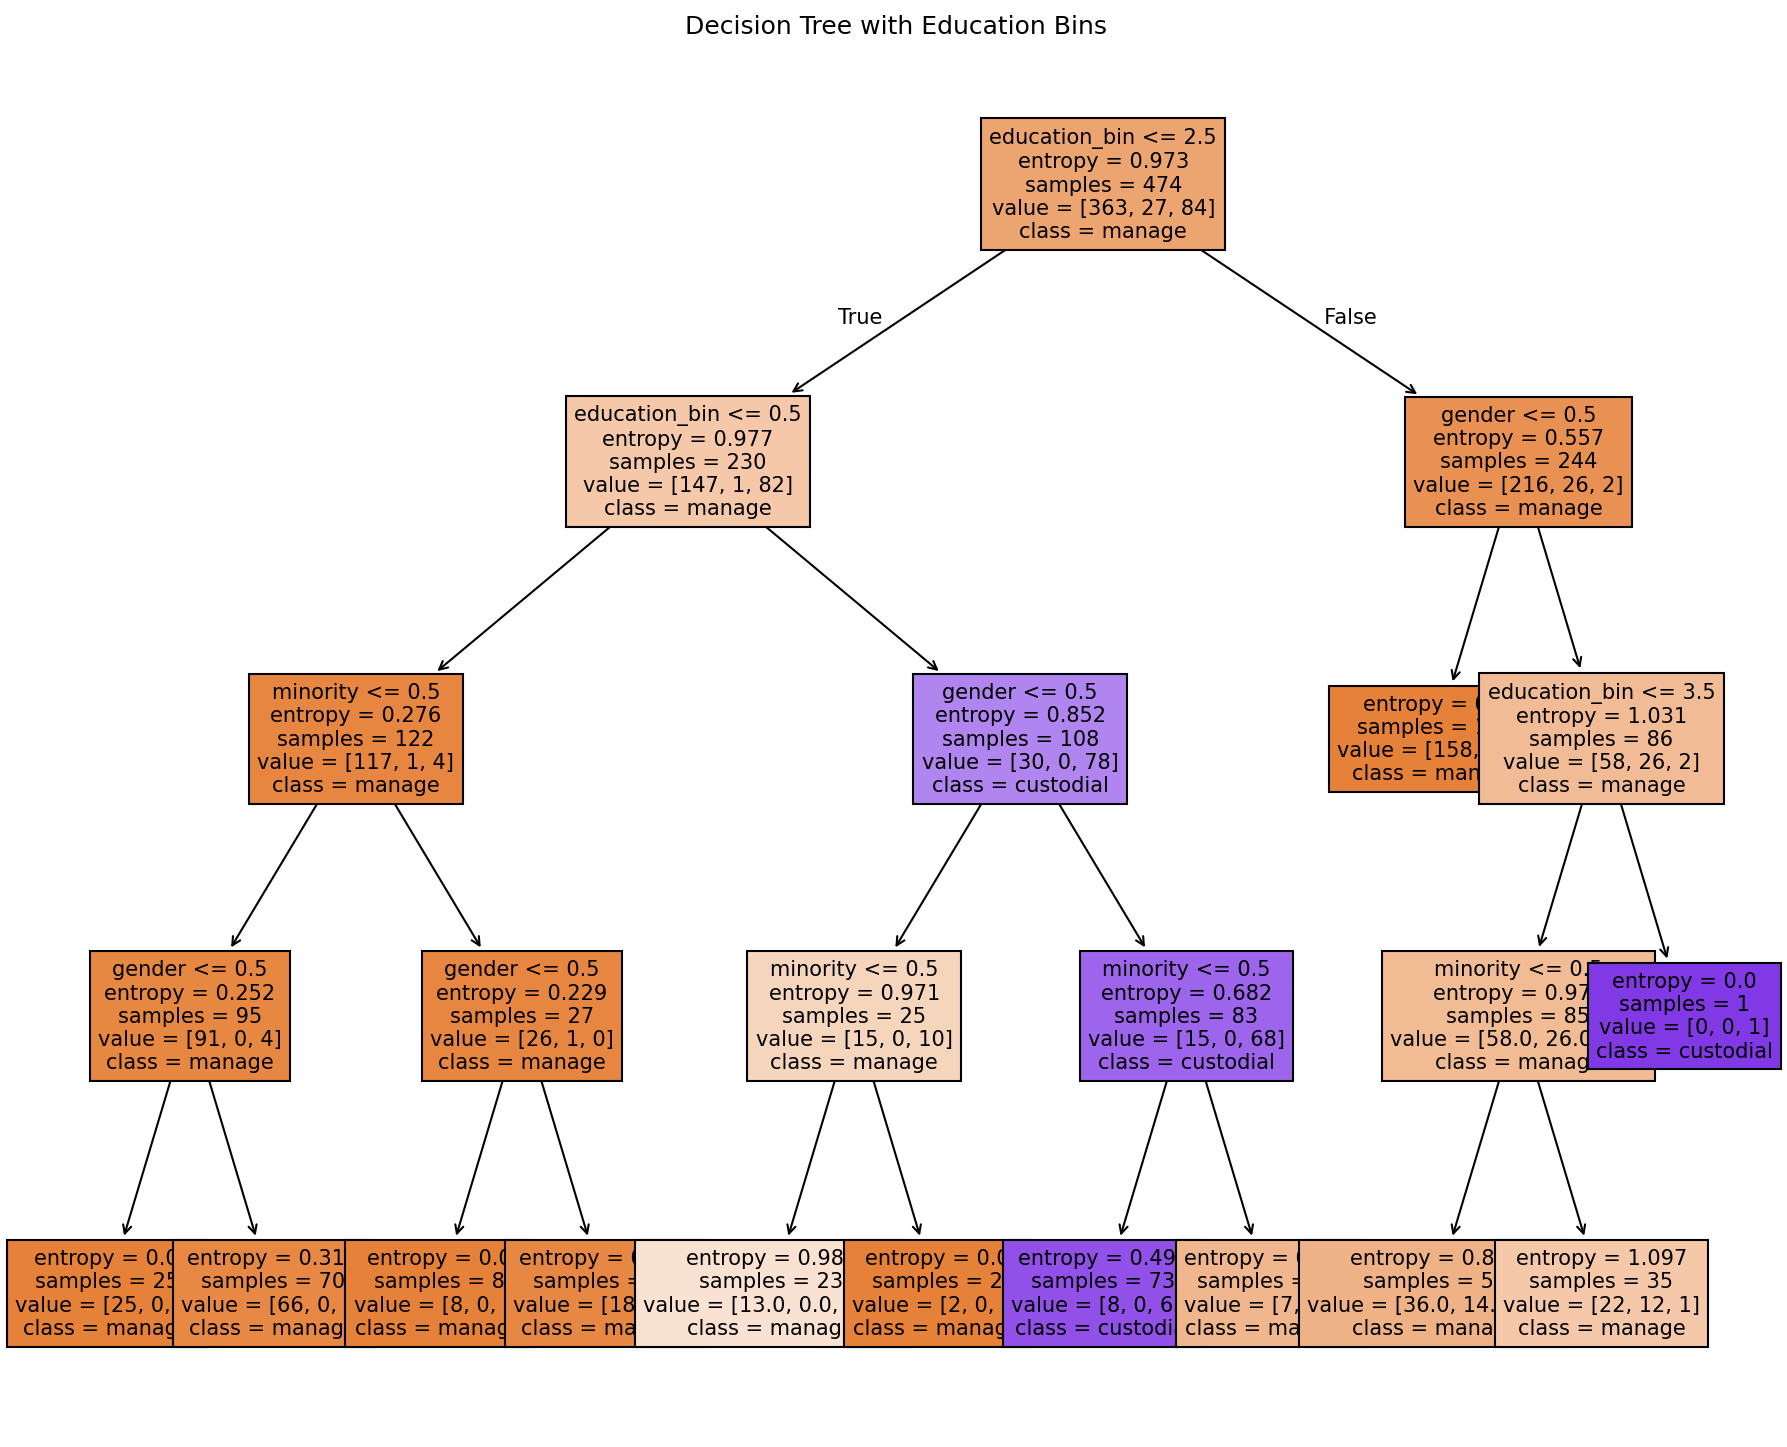

In [39]:
feature_names = ['education_bin', 'gender', 'minority']
class_names = list(target.unique())

fig, axes = plt.subplots(1, 1, figsize=(15, 12), dpi=150)
plot_tree(dtree, fontsize=10, filled=True,
          max_depth=4,
          feature_names=feature_names,
          class_names=class_names)
plt.title("Decision Tree with Education Bins")
plt.show()

Accuracy ratings:

In [40]:
predictions = dtree.predict(features)
accuracy = metrics.accuracy_score(target, predictions) * 100
print(f"\nThe accuracy of our model is: {accuracy:.2f}%")


The accuracy of our model is: 88.82%
